In [1]:
import random
import numpy as np
import os
import sys
import torch
from torchvision.transforms import transforms
from torchvision import datasets
from collections import Counter
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset, ConcatDataset, random_split
import numpy as np
from copy import deepcopy
import numpy as np
import torch
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

In [2]:
# Check if running on Colab
try:
  import google.colab
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  from google.colab import drive
  # Connect to Google drive where the training data is located
  drive.mount("/content/gdrive")
  work_dir = "/content/gdrive/My Drive/Colab Notebooks/DL-Project-2024-Experiments/SUBMISSION"
  os.chdir(work_dir)
  print(f"Connected to Google drive, setting working directory to '{work_dir}'")

Mounted at /content/gdrive
Connected to Google drive, setting working directory to '/content/gdrive/My Drive/Colab Notebooks/DL-Project-2024-Experiments/SUBMISSION'


In [3]:
# Check if GPUs are available
device=torch.device("cpu")
if torch.cuda.is_available():
    device=torch.device("cuda")
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
print(f"Device: {device}")

# Check system
print(f"Number of CPUs: {os.cpu_count()}")
print(f"System version: {sys.version_info}")

Number of available GPUs: 1
Device: cuda
Number of CPUs: 12
System version: sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [4]:
# Create results folder if it does not exist yet
results_folder_name = 'train_all_results'
if not os.path.exists(results_folder_name):
    os.makedirs(results_folder_name)

In [5]:
EPOCHS=100
BATCH_SIZE=100
LEARNING_RATE=0.001
OPTIMIZER_MOMENTUM=0.9

In [6]:
# Load training data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True,
                            transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                           download=True,
                           transform=transform)

print(f"Loaded CIFAR10 data: training={len(trainset)} items, testing={len(testset)} items.")

Files already downloaded and verified
Files already downloaded and verified
Loaded CIFAR10 data: training=50000 items, testing=10000 items.


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
train_loader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False)
test_loader=DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
model = CNN()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=OPTIMIZER_MOMENTUM)
loss_fn = nn.CrossEntropyLoss()
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):

  # train
  model.train()
  train_running_loss=0.0
  train_n_correct=0
  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, y)
    train_n_correct+=(pred.argmax(1) == y).type(torch.float).sum().item()
    train_running_loss+=loss.item()
    loss.backward()
    optimizer.step()
  train_accuracy = train_n_correct/len(train_loader.dataset)
  train_accuracies.append(train_accuracy)

  # test
  model.eval()
  test_running_loss = 0.0
  test_n_correct=0.0
  for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)
    test_running_loss+=loss.item()
    test_n_correct+=(pred.argmax(1) == y).type(torch.float).sum().item()
  test_accuracy = test_n_correct/len(test_loader.dataset)
  test_accuracies.append(test_accuracy)
  print(f"Epoch [{epoch+1}/{EPOCHS}]: training accuracy={train_accuracy:.2%},  test accuracy={test_accuracy:.2%}")

Epoch [1/100]: training accuracy=12.30%,  test accuracy=16.37%
Epoch [2/100]: training accuracy=18.81%,  test accuracy=20.08%
Epoch [3/100]: training accuracy=24.51%,  test accuracy=27.52%
Epoch [4/100]: training accuracy=29.20%,  test accuracy=32.15%
Epoch [5/100]: training accuracy=33.64%,  test accuracy=35.99%
Epoch [6/100]: training accuracy=37.62%,  test accuracy=39.81%
Epoch [7/100]: training accuracy=41.08%,  test accuracy=42.54%
Epoch [8/100]: training accuracy=43.62%,  test accuracy=44.30%
Epoch [9/100]: training accuracy=45.70%,  test accuracy=46.10%
Epoch [10/100]: training accuracy=47.45%,  test accuracy=47.97%
Epoch [11/100]: training accuracy=49.03%,  test accuracy=49.51%
Epoch [12/100]: training accuracy=50.58%,  test accuracy=50.79%
Epoch [13/100]: training accuracy=51.82%,  test accuracy=52.00%
Epoch [14/100]: training accuracy=52.98%,  test accuracy=52.91%
Epoch [15/100]: training accuracy=53.98%,  test accuracy=53.77%
Epoch [16/100]: training accuracy=54.94%,  test a

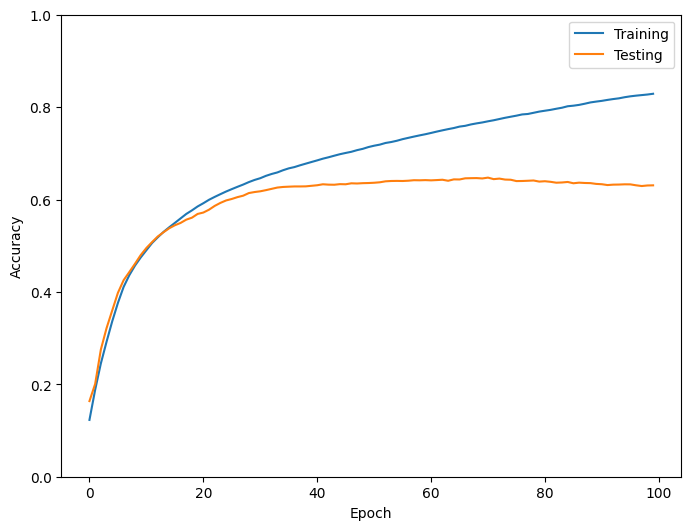

In [9]:
epochs=np.arange(0,EPOCHS)
plt.figure(figsize=(8,6))
plt.plot(epochs, train_accuracies, label="Training", color="tab:blue")
plt.plot(epochs, test_accuracies, label="Testing", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.0,1.0)
plt.legend()
plt.savefig(f"{results_folder_name}/full_training.png")